In [86]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt,joblib
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score,average_precision_score
from sklearn.metrics import adjusted_mutual_info_score,balanced_accuracy_score,roc_curve,auc

#Deep Learning
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'tensorflow'

In [87]:
#Import Data
df=pd.read_csv('loan_prediction.csv')

In [88]:
#Check head
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [89]:
#Check info
df.info()
#From the info we can see that there is missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [90]:
#Check null value counts
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [91]:
#From the data we can see that there are maximum male so we will uimpute null values with most frequent
df['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [92]:
#Impute most frequent values in Gender Column
si=SimpleImputer(strategy='most_frequent')
df['Gender']=si.fit_transform(df['Gender'].values.reshape(-1,1))

In [93]:
#Check null value counts
df.isna().sum()

Loan_ID               0
Gender                0
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [94]:
#There is not much difference between two distinct values in Married column
#So we will fill null values with most frequent 'Yes'
df['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [95]:
df['Married']=df['Married'].replace(np.nan,'Yes')

In [96]:
df['Married'].value_counts()

Yes    401
No     213
Name: Married, dtype: int64

In [97]:
df['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [98]:
#We will do EDA to check more on filling positions of Dependants
df[df['Dependents'].isna()]['Married'].value_counts()

Yes    11
No      4
Name: Married, dtype: int64

In [99]:
df[df['Married']=='No']['Dependents'].value_counts()
#As we can see for most of the people who are not married doesnot have any dependents

0     171
1      23
2       8
3+      7
Name: Dependents, dtype: int64

In [100]:
df['Dependents']=df['Dependents'].replace(np.nan,'Null')

In [101]:
def fill_dep(marr,dep):
    if dep=='Null':
        if marr=='No':
            return '0'
        else:
            return dep
    else:
        return dep

In [102]:
df['Dependents']=df.apply(lambda x:fill_dep(x['Married'],x['Dependents']),axis=1)

In [103]:
df[df['Dependents']=='Null']

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
102,LP001350,Male,Yes,Null,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
104,LP001357,Male,Yes,Null,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
120,LP001426,Male,Yes,Null,Graduate,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
226,LP001754,Male,Yes,Null,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
228,LP001760,Male,Yes,Null,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
301,LP001972,Male,Yes,Null,Not Graduate,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y
335,LP002106,Male,Yes,Null,Graduate,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y
346,LP002130,Male,Yes,Null,Not Graduate,No,3523,3230.0,152.0,360.0,0.0,Rural,N
435,LP002393,Female,Yes,Null,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y
517,LP002682,Male,Yes,Null,Not Graduate,No,3074,1800.0,123.0,360.0,0.0,Semiurban,N


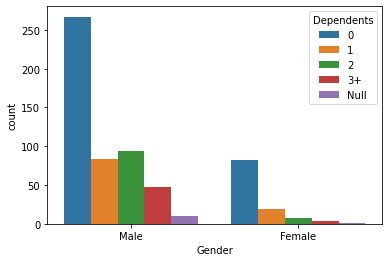

In [104]:
sns.countplot(x='Gender',data=df,hue='Dependents')
plt.show()
#From the below graph we can see that the most of the males had 0 depedents so we will impute 0 for other 
#rows too

In [105]:
df['Dependents']=df['Dependents'].replace('Null','0')

In [106]:
df['Dependents'].value_counts()

0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [107]:
df.isna().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [108]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [109]:
df[df['Self_Employed'].isna()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
11,LP001027,Male,Yes,2,Graduate,NaN,2500,1840.0,109.0,360.0,1.0,Urban,Y
19,LP001041,Male,Yes,0,Graduate,NaN,2600,3500.0,115.0,NaN,1.0,Urban,Y
24,LP001052,Male,Yes,1,Graduate,NaN,3717,2925.0,151.0,360.0,NaN,Semiurban,N
29,LP001087,Female,No,2,Graduate,NaN,3750,2083.0,120.0,360.0,1.0,Semiurban,Y
30,LP001091,Male,Yes,1,Graduate,NaN,4166,3369.0,201.0,360.0,NaN,Urban,N
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N
107,LP001370,Male,No,0,Not Graduate,NaN,7333,0.0,120.0,360.0,1.0,Rural,N
111,LP001387,Female,Yes,0,Graduate,NaN,2929,2333.0,139.0,360.0,1.0,Semiurban,Y
114,LP001398,Male,No,0,Graduate,NaN,5050,0.0,118.0,360.0,1.0,Semiurban,Y
158,LP001546,Male,No,0,Graduate,NaN,2980,2083.0,120.0,360.0,1.0,Rural,Y


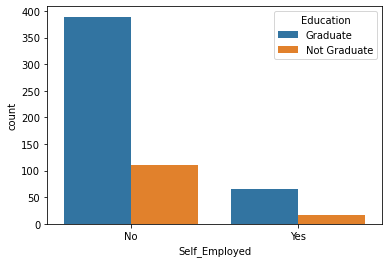

In [110]:
sns.countplot(x='Self_Employed',data=df,hue='Education')
plt.show()
#There does not seem any direct link between Self Employement so we will impute most frequent values

In [111]:
si=SimpleImputer(strategy='most_frequent')
df['Self_Employed']=si.fit_transform(df['Self_Employed'].values.reshape(-1,1))

In [112]:
df.isna().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

for LoanAmount we might directly drop the rows as it might have high correlation with Loan_Status
Hence we don't want to impute any false values
We will consider this column after checking correlation

In [113]:
df['Loan_Amount_Term'].value_counts()
#Impute most frequent value

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [114]:
si=SimpleImputer(strategy='most_frequent')
df['Loan_Amount_Term']=si.fit_transform(df['Loan_Amount_Term'].values.reshape(-1,1))

In [115]:
df.isna().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [116]:
df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [117]:
si=SimpleImputer(strategy='most_frequent')
df['Credit_History']=si.fit_transform(df['Credit_History'].values.reshape(-1,1))

In [118]:
#We will have to encode below columns
df.select_dtypes('object').columns.tolist()

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [119]:
#Loan ID can be dropped directly as they are unique values
df['Loan_ID'].value_counts()

LP002705    1
LP001585    1
LP001087    1
LP002031    1
LP002328    1
           ..
LP002143    1
LP002347    1
LP001900    1
LP002103    1
LP002434    1
Name: Loan_ID, Length: 614, dtype: int64

In [120]:
df=df.drop('Loan_ID',axis=1)

In [121]:
#We will have to encode below columns
df.select_dtypes('object').columns.tolist()

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [122]:
df['Gender'].value_counts()
#We can labelencode this column

Male      502
Female    112
Name: Gender, dtype: int64

In [123]:
le=LabelEncoder()
df['Gender']=le.fit_transform(df['Gender'])

In [124]:
#We will have to encode below columns
df.select_dtypes('object').columns.tolist()

['Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [125]:
df['Married'].value_counts()

Yes    401
No     213
Name: Married, dtype: int64

In [126]:
le=LabelEncoder()
df['Married']=le.fit_transform(df['Married'])

we are not creating function for this as we will encode columns with two variable with LabelEncoder
But columns with multiple values we will use OneHotEncoder

In [127]:
#We will have to encode below columns
df.select_dtypes('object').columns.tolist()

['Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

In [128]:
oe=OneHotEncoder()
df_dep=oe.fit_transform(df['Dependents'].values.reshape(-1,1)).toarray()

In [129]:
df_dep.shape

(614, 4)

In [130]:
df_dep=pd.DataFrame(df_dep,columns=['Dep_'+str(x) for x in range(df_dep.shape[1])])

In [131]:
df=pd.concat([df.drop('Dependents',axis=1),df_dep],axis=1)

In [132]:
#We will have to encode below columns
df.select_dtypes('object').columns.tolist()

['Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

In [133]:
df['Education'].value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [134]:
le=LabelEncoder()
df['Education']=le.fit_transform(df['Education'])

In [135]:
#We will have to encode below columns
df.select_dtypes('object').columns.tolist()

['Self_Employed', 'Property_Area', 'Loan_Status']

In [136]:
df['Self_Employed'].value_counts()

No     532
Yes     82
Name: Self_Employed, dtype: int64

In [137]:
le=LabelEncoder()
df['Self_Employed']=le.fit_transform(df['Self_Employed'])

In [138]:
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

In [139]:
le=LabelEncoder()
df['Property_Area']=le.fit_transform(df['Property_Area'])

In [140]:
le=LabelEncoder()
df['Loan_Status']=le.fit_transform(df['Loan_Status'])

In [141]:
df.corr()['Loan_Status'].sort_values(ascending=False)
#As we can see LoanAmount is not highly correlated with Loan Status so we will impute mean values for missing data

Loan_Status          1.000000
Credit_History       0.540556
Married              0.091478
Dep_2                0.062384
Property_Area        0.032112
Gender               0.017987
Dep_0               -0.003044
Self_Employed       -0.003700
ApplicantIncome     -0.004710
Loan_Amount_Term    -0.022549
Dep_3               -0.026123
LoanAmount          -0.037318
Dep_1               -0.038740
CoapplicantIncome   -0.059187
Education           -0.085884
Name: Loan_Status, dtype: float64

<AxesSubplot:xlabel='Loan_Status', ylabel='Credit_History'>

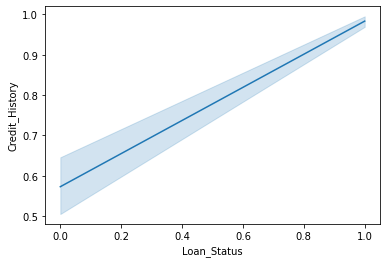

In [142]:
#As we can see there is linear relation between Loan Status and Credit History
sns.lineplot(x='Loan_Status',y='Credit_History',data=df)

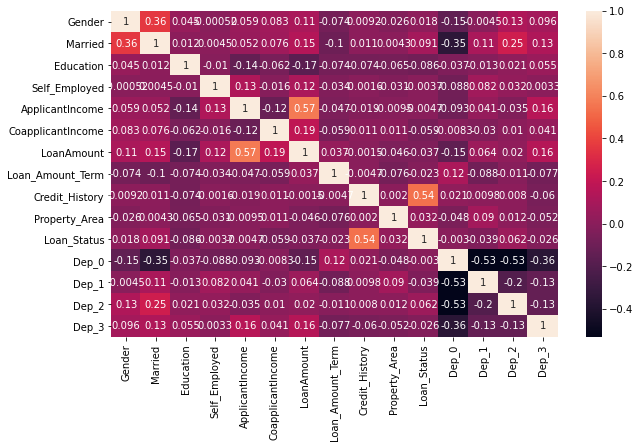

In [143]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True)
plt.show()

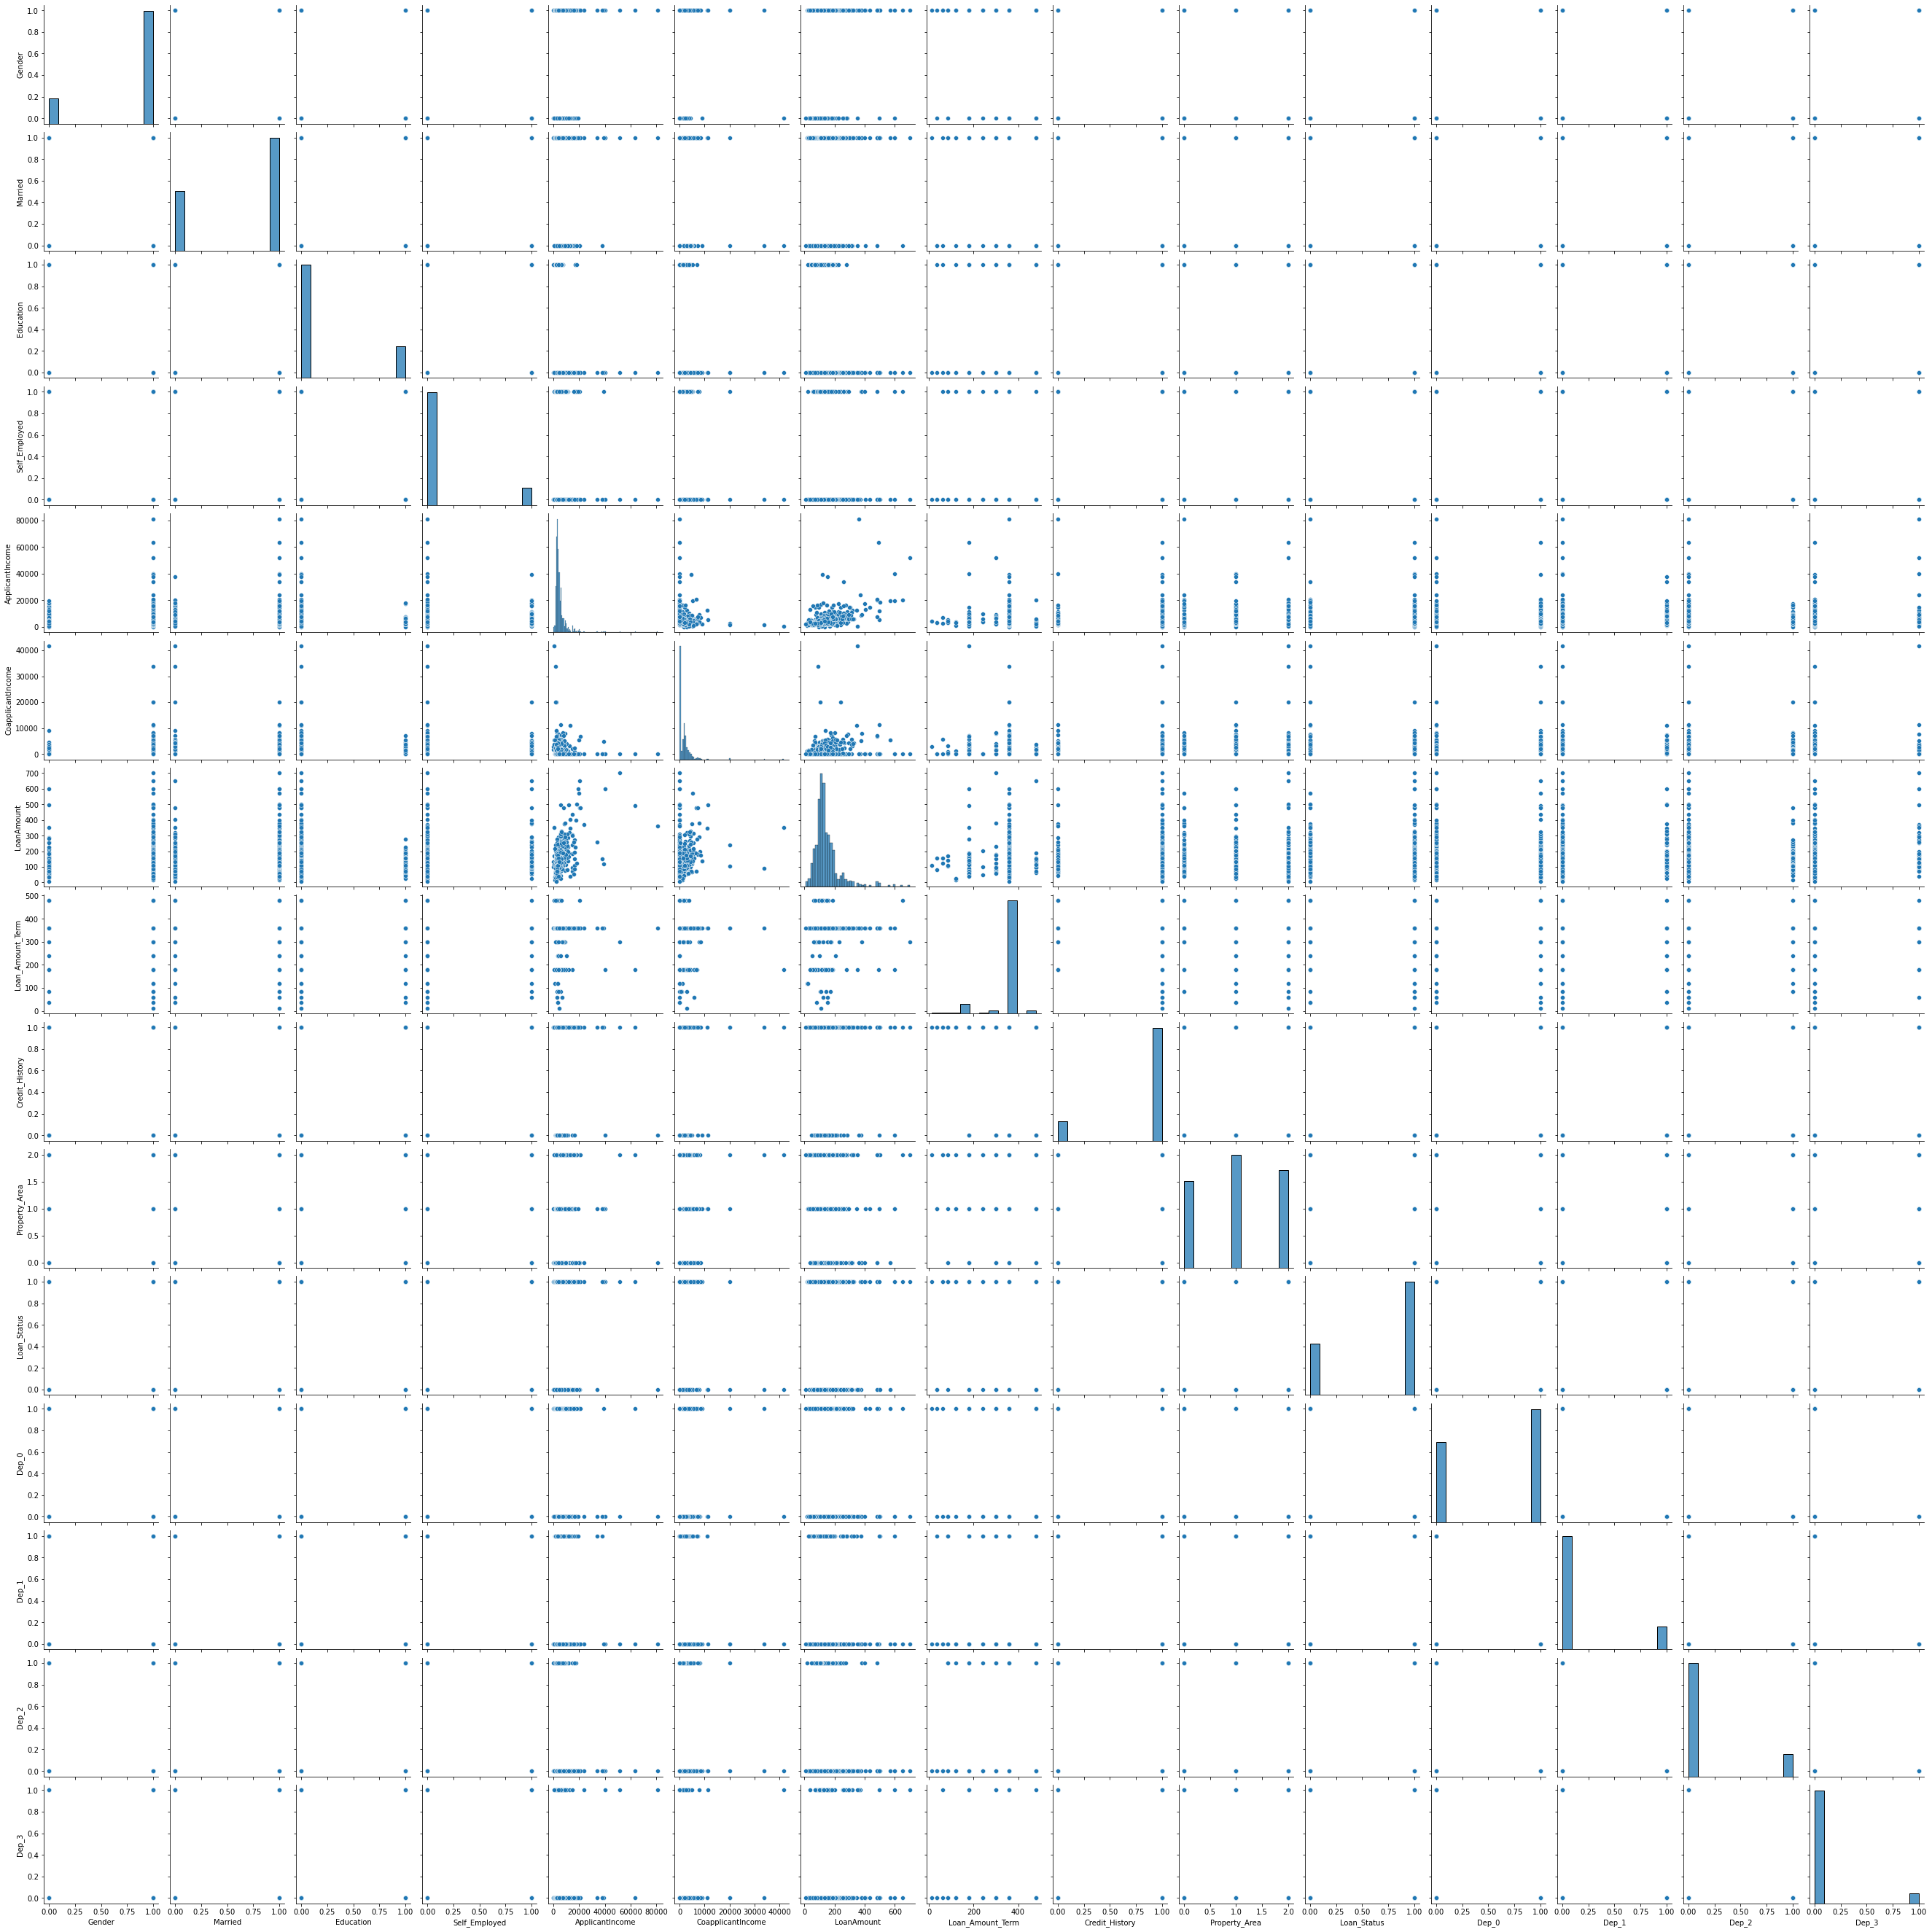

In [149]:
sns.pairplot(df)
plt.show()

In [150]:
zs=zscore(df)
df=df[((zs>-3) & (zs<3)).all(axis=1)]

In [151]:
df.shape
#At first there were 614 rows now there are 533

(0, 15)

In [153]:
#Check Skewness
df.skew()

Gender              NaN
Married             NaN
Education           NaN
Self_Employed       NaN
ApplicantIncome     NaN
CoapplicantIncome   NaN
LoanAmount          NaN
Loan_Amount_Term    NaN
Credit_History      NaN
Property_Area       NaN
Loan_Status         NaN
Dep_0               NaN
Dep_1               NaN
Dep_2               NaN
Dep_3               NaN
dtype: float64

In [ ]:
pt=PowerTransformer()

In [65]:
for x in df.columns.drop('Loan_Status'):
    if abs(df[x].skew())>0.55:
        df.loc[:,x]=pt.fit_transform(df.loc[:,x].values.reshape(-1,1))

In [66]:
df.skew()

Gender              -1.648795
Married             -0.644850
Education            1.367622
Self_Employed        2.159796
ApplicantIncome     -0.092946
CoapplicantIncome   -0.145646
LoanAmount           0.019766
Loan_Amount_Term     0.392571
Credit_History      -2.021971
Property_Area       -0.066196
Loan_Status         -0.809998
Dep_0               -0.351399
Dep_1                1.798506
Dep_2                1.814433
Dep_3                3.028961
dtype: float64

In [154]:
scale=MinMaxScaler()
X=df.drop('Loan_Status',axis=1)
y=df['Loan_Status']
X=scale.fit_transform(X)

ValueError: Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required by MinMaxScaler.

In [70]:
#Define a function to try different train test folds
def model_select(model):
    max_score=0
    max_state=0
    for x in range(42,105):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=x)
        md=model
        md.fit(X_train,y_train)
        predict=md.predict(X_test)
        fpr,tpr,thresholds=roc_curve(y_test,predict)
        acurve=auc(fpr,tpr)
#         f1=f1_score(y_test,predict)
        acc=accuracy_score(y_test,predict)
#         avg=(confusion_matrix(y_test,predict)[0,0]+confusion_matrix(y_test,predict)[1,1])/(confusion_matrix(y_test,predict)[0,1]+confusion_matrix(y_test,predict)[1,0])
        if acc>max_score:
            max_score=acc
            max_state=x
    print("Max score is {} with random state {}".format(max_score,max_state))

In [71]:
#Call the function
model_select(LogisticRegression(max_iter=4000))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [72]:
#Call the function
model_select(KNeighborsClassifier())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [73]:
#Call the function
model_select(SVC())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [74]:
#Call the function
model_select(DecisionTreeClassifier())

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [75]:
#Call the function
model_select(RandomForestClassifier())

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [76]:
#Call the function
model_select(AdaBoostClassifier())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [77]:
#Call the function
model_select(GaussianNB())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#Call the function
model_select(BaggingClassifier())

In [78]:
#Call the function
model_select(GradientBoostingClassifier())

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64)
model=LogisticRegression(max_iter=4000,solver='liblinear')
model.fit(X_train,y_train)
predict=model.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [80]:
print(confusion_matrix(y_test,predict))
print()
print(classification_report(y_test,predict))

NameError: name 'predict' is not defined

In [81]:
param={'C':[0.1,0.3,0.5,0.7,0.9,1]}
gscv=GridSearchCV(LogisticRegression(max_iter=4000),param_grid=param)

In [82]:
gscv.fit(X_train,y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 795, in check_X_y
    X = check_array(X, accept_sparse=ac

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [83]:
gscv.best_params_

{'C': 0.1}

In [84]:
model=LogisticRegression(max_iter=4000,C=0.3)
model.fit(X_train,y_train)
predict=model.predict(X_test)print(confusion_matrix(y_test,predict))
print()
print(classification_report(y_test,predict))

SyntaxError: invalid syntax (<ipython-input-84-d53438629d23>, line 3)

In [85]:
joblib.dump(model,'Loan Status Logistic.obj')

['Loan Status Logistic.obj']